In [9]:
import pathpyG as pp
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
from collections import defaultdict, deque
import numpy as np
import time

In [10]:
df = pd.read_csv('out.mit', delim_whitespace=True, header=None, skiprows=1)
df = df.drop(columns=2)
df.columns = ['source', 'destination', 'timestamp']
df.head()

/tmp/ipykernel_1896692/2260482340.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv('out.mit', delim_whitespace=True, header=None, skiprows=1)


,source,destination,timestamp
0,1,2,1095183096
1,3,4,1095183096
2,5,6,1095183096
3,7,8,1095183096
4,9,2,1095183096


In [11]:
# Drop rows with missing values
df.dropna(inplace=True)  
# Convert cleaned DataFrame to list of tuples (source, destination, timestamp)
data_tuples = list(df.itertuples(index=False, name=None))

In [12]:
print(len(df))

1086404


In [13]:
# Step 1: Extract and sort timestamps
timestamps = df['timestamp'].sort_values().to_numpy()

# Step 2: Calculate time intervals
intervals = np.diff(timestamps)

# Step 3: Calculate average interval
average_interval = np.mean(intervals)

print(f"Average time interval: {average_interval} seconds")

Average time interval: 18.474359883026832 seconds


In [14]:
# Define the PaCo algorithm
def paco(data, delta, max_length):
    """
    Implements the PaCo algorithm for counting causal paths in temporal networks.
    
    Args:
    - data: List of tuples (source, destination, timestamp).
    - delta: Maximum time difference between consecutive links.
    - max_length: Maximum path length (K).
    
    Returns:
    - path_counts: Dictionary of causal paths and their counts.
    """
    # Sort data by timestamp
    data = sorted(data, key=lambda x: x[2])
    
    # Initialize sliding window and path counters
    window = deque()  # Sliding window
    path_counts = defaultdict(int)  # Overall causal path counts
    
    # Iterate through each link in the data
    for (s, d, t) in data:
        current_counts = defaultdict(int)  # Local counts for current link
        current_counts[(s, d)] = 1  # A single link is a causal path of length 1
        
        # Update the sliding window: remove outdated links
        while window and window[0][2] < t - delta:
            window.popleft()
        
        # Extend paths from the sliding window
        for (prev_s, prev_d, prev_t, prev_counts) in window:
            if prev_d == s and prev_t < t:  # Valid path extension
                for path, count in prev_counts.items():
                    if len(path) < max_length:  # Enforce maximum path length
                        extended_path = path + (d,)
                        current_counts[extended_path] += count
        
        # Update global counts
        for path, count in current_counts.items():
            path_counts[path] += count
        
        # Add current link and its paths to the sliding window
        window.append((s, d, t, current_counts))
    
    return path_counts


In [ ]:
delta_values = [1200, 1800, 2400, 3000]
max_length_values = [2, 3, 4, 5, 6, 7, 8, 9, 10]
found_paths = []
# Loop through the values and measure execution time
for delta in delta_values:
    for max_length in max_length_values:
        start_time = time.time()  # Record start time
        results = paco(data_tuples, delta, max_length)
        end_time = time.time()  # Record end time
        found_paths.append([len(results), delta, max_length]) # add the amount of found paths to a list to keep track of the increase in found paths
        elapsed_time = end_time - start_time  # Calculate elapsed time   
        print(f"Max Time Delta: {delta}, Max length: {max_length} -> Time Taken: {elapsed_time:.4f} seconds")

Max Time Delta: 1200, Max length: 2 -> Time Taken: 4.5301 seconds
Max Time Delta: 1200, Max length: 3 -> Time Taken: 5.0506 seconds
Max Time Delta: 1200, Max length: 4 -> Time Taken: 5.5259 seconds
Max Time Delta: 1200, Max length: 5 -> Time Taken: 5.9957 seconds
Max Time Delta: 1200, Max length: 6 -> Time Taken: 6.4691 seconds
Max Time Delta: 1200, Max length: 7 -> Time Taken: 6.5817 seconds
Max Time Delta: 1200, Max length: 8 -> Time Taken: 6.8449 seconds
Max Time Delta: 1200, Max length: 9 -> Time Taken: 6.8561 seconds
Max Time Delta: 1200, Max length: 10 -> Time Taken: 6.7565 seconds
Max Time Delta: 1800, Max length: 2 -> Time Taken: 5.9834 seconds
Max Time Delta: 1800, Max length: 3 -> Time Taken: 6.9785 seconds
Max Time Delta: 1800, Max length: 4 -> Time Taken: 7.5836 seconds
Max Time Delta: 1800, Max length: 5 -> Time Taken: 8.4883 seconds
Max Time Delta: 1800, Max length: 6 -> Time Taken: 9.0817 seconds
Max Time Delta: 1800, Max length: 7 -> Time Taken: 9.3462 seconds
Max Time 

In [ ]:
print(found_paths)

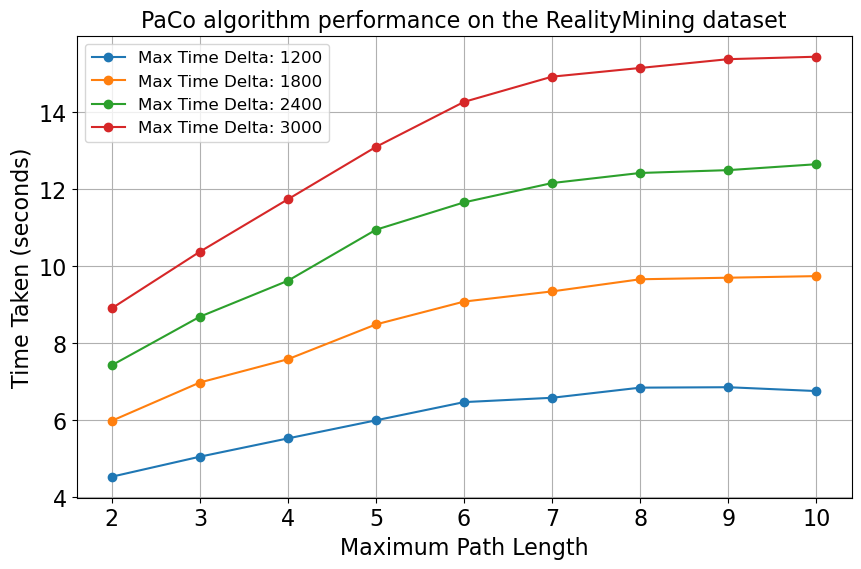

In [23]:
time_deltas = [1200, 1800, 2400, 3000]
max_lengths = [2, 3, 4, 5, 6, 7, 8, 9, 10]
times = {
    1200: [4.5301, 5.0506, 5.5259, 5.9957, 6.4691, 6.5817, 6.8449, 6.8561, 6.7565],
    1800: [5.9834, 6.9785, 7.5836, 8.4883, 9.0817, 9.3462, 9.6615, 9.7020, 9.7434],
    2400: [7.4259, 8.6880, 9.6228, 10.9488, 11.6595, 12.1620, 12.4240, 12.4976, 12.6512],
    3000: [8.9068, 10.3772, 11.7403, 13.1016, 14.2713, 14.9269, 15.1529, 15.3816, 15.4451]
}
# Plotting
plt.figure(figsize=(10, 6))

for delta in time_deltas:
    plt.plot(max_lengths, times[delta], marker='o', label=f'Max Time Delta: {delta}')

# Labels and legend
plt.xlabel('Maximum Path Length', fontsize=16)
plt.ylabel('Time Taken (seconds)', fontsize=16)
plt.title('PaCo algorithm performance on the RealityMining dataset', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.xticks(range(2, 11), fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [5]:
# turn dataframe into graph to find some graph attributes
G_reality = nx.DiGraph()
for index, row in df.iterrows():
    G_reality.add_edge(row['source'], row['destination'], timestamp=row['timestamp'])

In [21]:
print(nx.density(G_reality))
print(nx.average_clustering(G_reality))

0.27839912280701756
0.3757513751177166


In [6]:
#convert data into format readable for the baseline algorithm
call_edge_list = list(df.itertuples(index=False, name=None))
graph = pp.TemporalGraph.from_edge_list(call_edge_list)

: 

In [ ]:
delta_values = [600, 1200, 1800]
max_order_values = [2, 3, 4, 5]

for delta in delta_values:
    for max_order in max_order_values:
        start_time = time.time()  
        temporal_paths = pp.MultiOrderModel.from_temporal_graph(graph, delta=delta, max_order=max_order)
        end_time = time.time()  
        elapsed_time = end_time - start_time  
        
        print(f"Delta: {delta}, Max Order: {max_order} -> Time Taken: {elapsed_time:.4f} seconds")

100%|██████████| 33452/33452 [00:15<00:00, 2118.63it/s]


Delta: 600, Max Order: 2 -> Time Taken: 18.0992 seconds


100%|██████████| 33452/33452 [00:18<00:00, 1785.39it/s]


Delta: 600, Max Order: 3 -> Time Taken: 23.8029 seconds


100%|██████████| 33452/33452 [00:15<00:00, 2116.17it/s]


Delta: 600, Max Order: 4 -> Time Taken: 34.1734 seconds


100%|██████████| 33452/33452 [00:16<00:00, 1974.93it/s]


Delta: 600, Max Order: 5 -> Time Taken: 86.9203 seconds


100%|██████████| 33452/33452 [00:16<00:00, 1970.63it/s]


: 

In [ ]:
temporal_paths = pp.MultiOrderModel.from_temporal_graph(graph, delta=1200, max_order=5)

100%|██████████| 33452/33452 [00:20<00:00, 1614.34it/s]


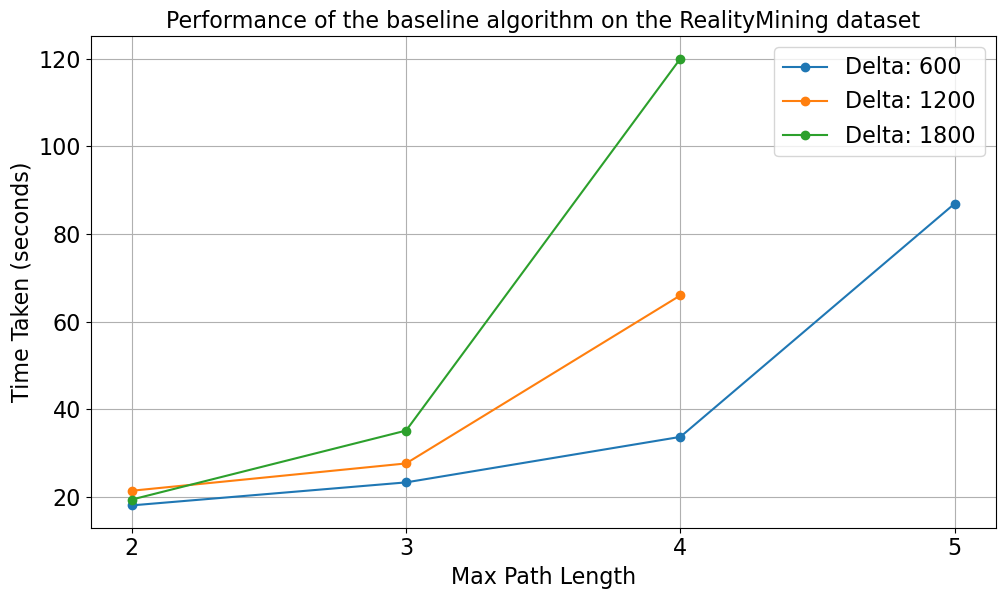

In [22]:
deltas = [600, 1200, 1800]
max_orders = [2, 3, 4, 5]
times = {
    600: [18.0830, 23.3305, 33.7113, 86.9203],
    1200: [21.4237, 27.6540, 65.9936, None],
    1800: [19.4134, 35.1509, 120, None]  # put none as these values were not computable (kernel kept crashing)
}

plt.figure(figsize=(10, 6))

# Loop through each delta to create a line for it
for delta in deltas:
    times_for_delta = times[delta]
    plt.plot(max_orders, times_for_delta, marker='o', label=f"Delta: {delta}")

plt.xlabel("Max Path Length", fontsize=16)
plt.ylabel("Time Taken (seconds)", fontsize=16)
plt.title("Performance of the baseline algorithm on the RealityMining dataset", fontsize=16)
plt.legend(fontsize=16)
plt.grid(True)
plt.tight_layout()
plt.xticks(range(2, 6), fontsize=16)
plt.yticks(fontsize=16)
plt.show()